In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest

%matplotlib inline
df = pd.read_csv('metadata.csv')



In [18]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(df):
    # Drop column: 'Path'
    df = df.drop(columns=['Path'])
    # Drop column: 'Other_species30'
    df = df.drop(columns=['Other_species30'])
    # Drop column: 'Other_species28'
    df = df.drop(columns=['Other_species28'])
    # Drop column: 'Other_species29'
    df = df.drop(columns=['Other_species29'])
    # Drop column: 'Other_species27'
    df = df.drop(columns=['Other_species27'])
    # Drop column: 'Other_species26'
    df = df.drop(columns=['Other_species26'])
    # Drop column: 'Other_species25'
    df = df.drop(columns=['Other_species25'])
    # Drop column: 'Other_species24'
    df = df.drop(columns=['Other_species24'])
    # Drop column: 'Other_species23'
    df = df.drop(columns=['Other_species23'])
    # Drop column: 'Remarks'
    df = df.drop(columns=['Remarks'])
    # Drop column: 'Spectrogram_full'
    df = df.drop(columns=['Spectrogram_full'])
    # Drop column: 'Spectrogram_large'
    df = df.drop(columns=['Spectrogram_large'])
    # Drop column: 'Spectrogram_med'
    df = df.drop(columns=['Spectrogram_med'])
    # Drop column: 'Spectrogram_small'
    df = df.drop(columns=['Spectrogram_small'])
    # Drop column: 'file.name'
    df = df.drop(columns=['file.name'])
    # Convert Date column to datetime format
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    # Replace all instances of "?" with "" in column: 'Altitude'
    df['Altitude'] = df['Altitude'].replace(to_replace='?', value=np.nan)
    # Replace all instances of "" with "" in column: 'Time'
    df['Time'] = df['Time'].replace(to_replace='?', value=np.nan)
    # Ensure 'Altitude' and are numeric, coerce errors to NaN
    df['Altitude'] = pd.to_numeric(df['Altitude'], errors='coerce')
    # Drop rows with missing data in column: 'Date'
    df = df.dropna(subset=['Date','Altitude'])
    # Drop column: 'Url'
    df = df.drop(columns=['Url'])
    # Drop column: 'License'
    df = df.drop(columns=['License'])
    # Drop column: 'Audio_file'
    df = df.drop(columns=['Audio_file'])
    # Capitalize the first character in column: 'Locality'
    df['Locality'] = df['Locality'].str.title()
    return df

df_clean = clean_data(df.copy())
df = df_clean


In [19]:
# Convert Length from "minutes:seconds" format to total seconds
def convert_to_seconds(length):
    try:
        minutes, seconds = map(int, length.split(':'))
        return minutes * 60 + seconds
    except ValueError:
        return np.nan  # Handle invalid formats as NaN
    
df['Length_seconds'] = df['Length'].apply(convert_to_seconds)

df['Time'] = df['Time'].astype(str)

def convert_time_to_minutes(time_str):
    try:
        if ':' in time_str:
            hours, minutes = map(int, time_str.split(':'))
            return hours * 60 + minutes
        else:
            return np.nan  # Return NaN if the format is not as expected
    except (ValueError, AttributeError):
        return np.nan

df['Time_minutes'] = df['Time'].apply(convert_time_to_minutes)

In [20]:

df['YearMonth'] = df['Date'].dt.to_period('M')

# Group by Species and YearMonth and count occurrences of each Quality category
df_grouped = df.groupby(['Species', 'YearMonth']).agg({
    'Quality': lambda x: x.value_counts().to_dict()  # Get counts of each Quality category
}).reset_index()


df_grouped['Call_Count'] = df.groupby(['Species', 'YearMonth']).size().values


df_grouped['YearMonth'] = df_grouped['YearMonth'].dt.to_timestamp()

# Expand 'Quality' counts into separate columns for each category (e.g., A, B, unknown)
quality_df = df_grouped['Quality'].apply(pd.Series).fillna(0).astype(int)
quality_df.columns = ['Quality_A', 'Quality_B', 'Quality_unknown']

# Merge the expanded quality data back into the grouped dataframe
df_grouped = pd.concat([df_grouped.drop(columns=['Quality']), quality_df], axis=1)


In [21]:
# Analyze Trends for Conservation
trend_data = []

# Iterate over each species to calculate trends
for species, group in df_grouped.groupby('Species'):
    group = group.sort_values('YearMonth')
    X = np.arange(len(group)).reshape(-1, 1)  # Time index for trend analysis
    y_call_count = group['Call_Count'].values
    y_quality_a = group['Quality_A'].values
    
    # Fit linear regression for Call_Count trend
    call_count_model = LinearRegression()
    call_count_model.fit(X, y_call_count)
    call_count_trend = call_count_model.coef_[0]  # Slope of the trend

    # Fit linear regression for Quality_A trend
    quality_a_model = LinearRegression()
    quality_a_model.fit(X, y_quality_a)
    quality_a_trend = quality_a_model.coef_[0]  # Slope of the trend

    trend_data.append({
        'Species': species,
        'Call_Count_Trend': call_count_trend,
        'Quality_A_Trend': quality_a_trend
    })


trend_df = pd.DataFrame(trend_data)


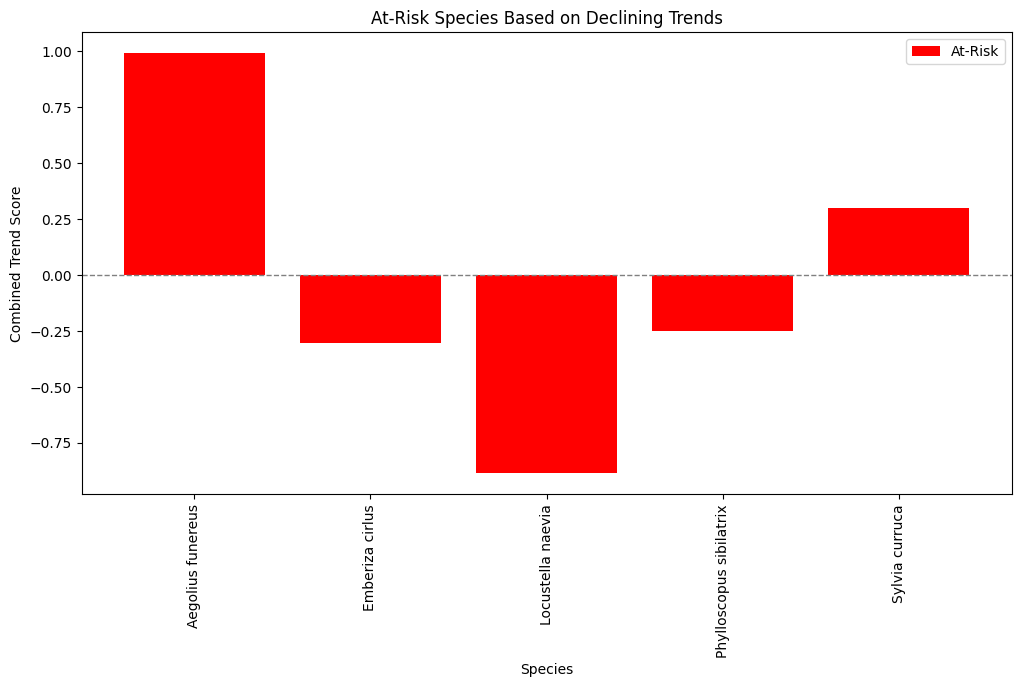

In [22]:
# Anomaly Detection for Declining Species
trend_df['Combined_Trend_Score'] = trend_df['Call_Count_Trend'] + trend_df['Quality_A_Trend']
iso_forest = IsolationForest(contamination=0.1, random_state=42)
trend_df['Risk_Anomaly'] = iso_forest.fit_predict(trend_df[['Combined_Trend_Score']])

# Visualize At-Risk Species
at_risk_species = trend_df[trend_df['Risk_Anomaly'] == -1]

plt.figure(figsize=(12, 6))
plt.bar(at_risk_species['Species'], at_risk_species['Combined_Trend_Score'], color='red', label='At-Risk')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('At-Risk Species Based on Declining Trends')
plt.xlabel('Species')
plt.ylabel('Combined Trend Score')
plt.legend()
plt.xticks(rotation=90)
plt.show()